# StatsBomb Intro

- [API Documentation](https://github.com/statsbomb/statsbombpy/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf)

## Work

- 2025-06-21
    - First exploration of statsbomb data
    - Make a heatmap of player occurrence each minute sorted by total occurrence
    - Make a try on plotting Player on the field

## Imports and loadings

In [19]:
from statsbombpy import sb
from mplsoccer import Pitch
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [20]:
CONF = {
    "competition_name": "Ligue 1",
    "season_name": "2022/2023",
    "team_name": "Paris Saint-Germain",
}

In [21]:
competitions = sb.competitions()

def get_competition(name, season_name):
    """Get competition ID by name and season."""
    comp = competitions[(competitions['competition_name'] == name) & 
                        (competitions['season_name'] == season_name)]
    if not comp.empty:
        return dict( name = name,
                    id = comp.iloc[0]['competition_id'],
                    season = season_name,
                    season_id = comp.iloc[0]['season_id'],
                    data = comp)
    else:
        raise ValueError(f"Competition {name} for season {season_name} not found.")

In [22]:
competition = get_competition(CONF['competition_name'], CONF['season_name'])
#competition

In [23]:
matches = sb.matches(competition_id=competition['id'], season_id=competition['season_id'])

def get_match(home_team, away_team):
    """Get match ID by home and away team names."""
    match = matches[(matches['home_team'] == home_team) & 
                    (matches['away_team'] == away_team) ]
    if not match.empty:
        return dict( home_team = home_team,
                     away_team = away_team,
                     id = match.iloc[0]['match_id'],
                     data = match)
    else:
        raise ValueError(f"Match between {home_team} and {away_team} not found in competition")

In [24]:
match = get_match(CONF['team_name'], 'Marseille')
#match

In [25]:
events = sb.events(match_id=match['id'])
events.columns

Index(['bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'injury_stoppage_in_chain',
       'interception_outcome', 'location', 'match_id', 'minute', 'off_camera',
       'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected',
       'pass_end_location', 'pass_goal_

## Heatmap Player occurrence vs. minutes over a single game

In [26]:
filter = events['minute']>=0# & events['type'] == 'Pass'
_events = events[filter]

_events = _events[['minute', 'player', 'team']]
_events['player_team'] = '(' + _events['team'] + ') ' + _events['player']
_events = _events[['minute','player_team']]
#fig, ax = plt.figure(figsize=(12, 6))

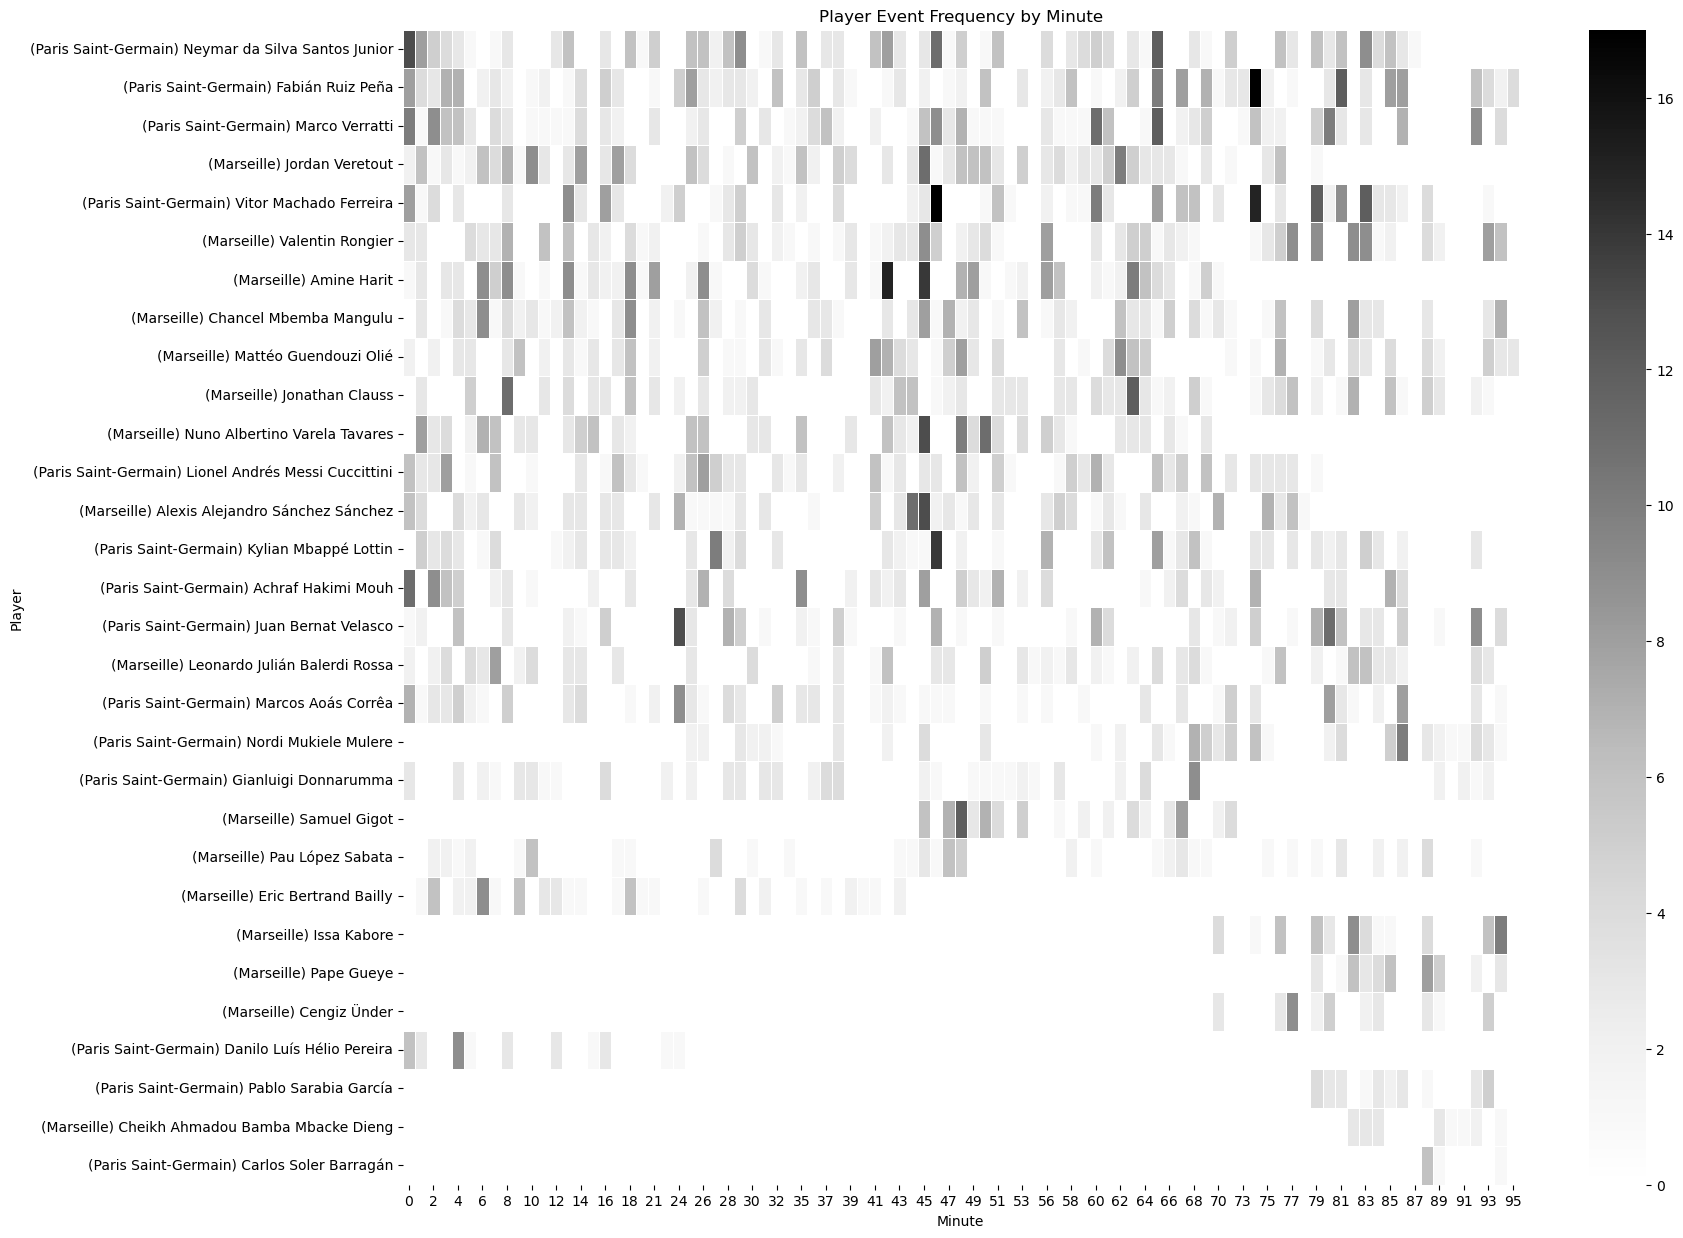

In [27]:
_events['minute_bin'] = _events['minute'].astype(int)

# Create a pivot table: rows=player, columns=minute, values=count of appearances
heatmap_data = _events.groupby(['player_team', 'minute_bin']).size().unstack(fill_value=0)
heatmap_data['tot'] = heatmap_data.sum(axis=1)
heatmap_data.sort_values(by='tot', ascending=False, inplace=True)
heatmap_data = heatmap_data[[c for c in heatmap_data.columns if c != 'tot']]

plt.figure(figsize=(18, len(heatmap_data) // 2))
sns.heatmap(heatmap_data, cmap="Greys", linewidths=0.5)
plt.xlabel("Minute")
plt.ylabel("Player")
plt.title("Player Event Frequency by Minute")
plt.show()
# ...existing code...

## Plot a player position on a Pitch

(0.0, 80.0)

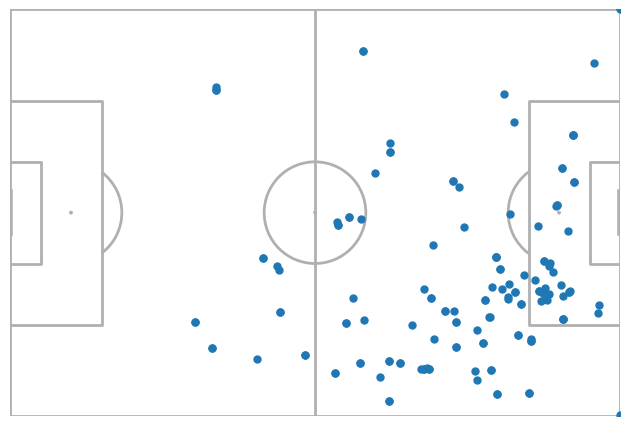

In [28]:
player = events[events.player_id == 3009]
player.loc[:,'xpos'] = player.loc[:,'location'].apply(lambda x: x[0] if isinstance(x, list) else None).copy()
player.loc[:,'ypos'] = player.loc[:,'location'].apply(lambda x: x[1] if isinstance(x, list) else None).copy()
player = player.sort_values(by='minute')

pitch = Pitch()
fig, ax = pitch.draw()
#fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(player.loc[:,'xpos'], player.loc[:,'ypos'], marker='o', linestyle='', markersize=5, label=player.iloc[0]['player'])
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)